# **Feature Selection in Convolve 2.0 Round 1**

**College: IIT Hyderabad**

**Authors: Vyaas, Padmaprabhan, Raghuveer, Shriram**

## **Importing the required dependencies**

In [144]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn_genetic.plots import plot_fitness_evolution
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn_genetic import GAFeatureSelectionCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

## **Loading the dataset**

In [145]:
df = pd.read_csv("Dataset.csv")

In [146]:
df = df.drop(df.columns[0], axis=1)
df.head

<bound method NDFrame.head of        x_1  x_109  x_113  x_12  x_124  x_127  x_144  x_16  x_18  x_2  ...  \
0     5099      1      5   156     35     -2      1    40   999    7  ...   
1     5191      0      1   164     16      1      5     4   999    5  ...   
2     5228      1      0   774     75      1      5    12   999    4  ...   
3     5228      1      1   747      4      1      5    69   999    3  ...   
4     5196      1      5    29     28      0      4    32   999    6  ...   
...    ...    ...    ...   ...    ...    ...    ...   ...   ...  ...  ...   
4114  5228      1      5   197     82      1      5     6   999    4  ...   
4115  5228      1      5   949     72      1      5     2   999    6  ...   
4116  5099      1      1   478     41     -2      1    25   999    1  ...   
4117  5228      1      0   554     36      1      5    68   999    0  ...   
4118  5196      1      0   143     26      0      4    21   999    1  ...   

      x_73  x_77  x_78  x_8  x_80  x_83  x_89

## **Visualizing correlations between features**

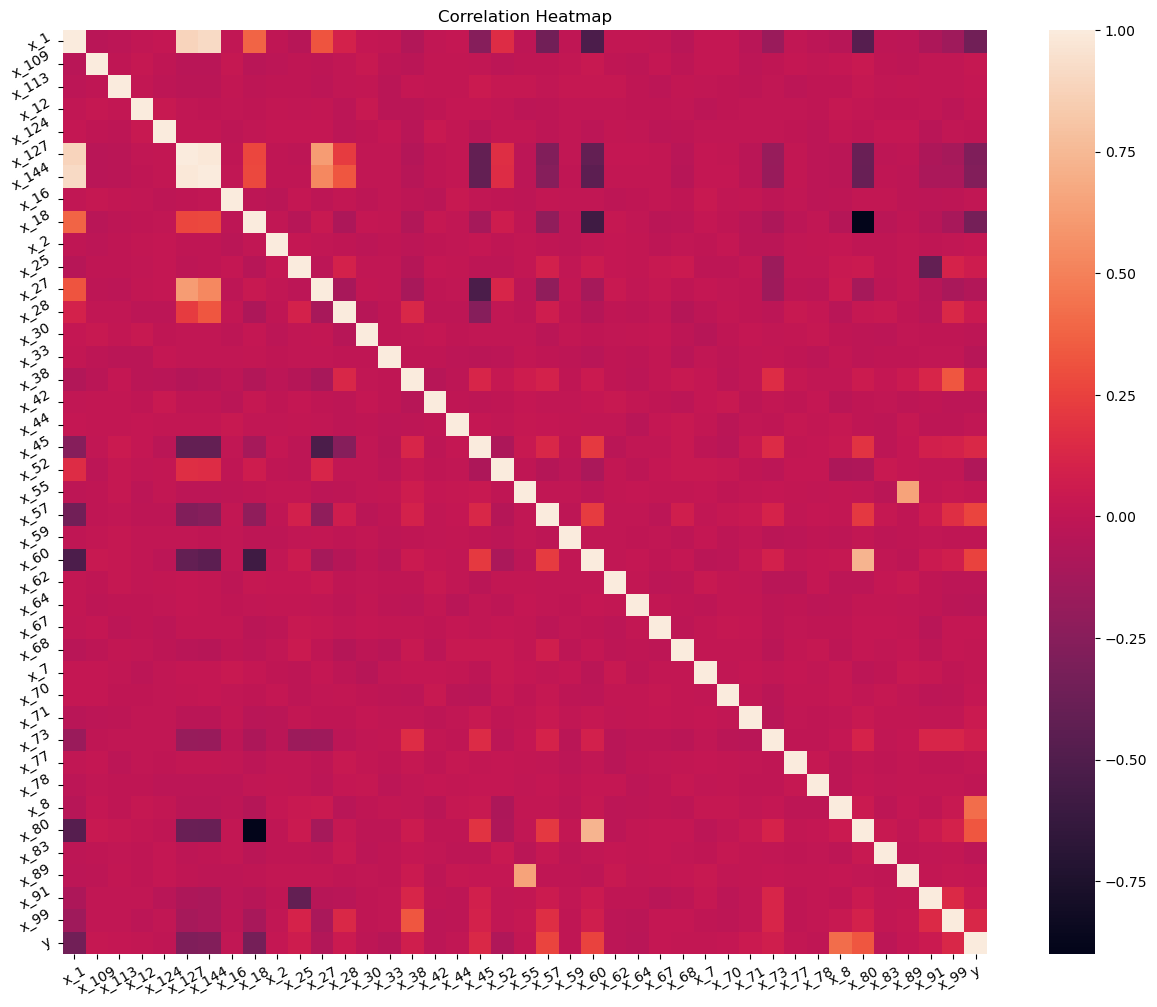

In [147]:
corr_matrix = df.corr()
plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap')
a = sns.heatmap(corr_matrix, square=True, fmt='.2f', linecolor='black')
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()

## **Data cleaning**

In [148]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(labels=['y'], axis=1), df['y'], test_size=0.3, random_state=0)

In [149]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.95)
print('correlated features: ', len(set(corr_features)))

X_train = X_train.drop(labels=corr_features, axis=1)
X_test = X_test.drop(labels=corr_features, axis=1)

correlated features:  1


In [150]:
corr_features

{'x_144'}

In [151]:
# normalizing the dataset for variance threshold
norm = MinMaxScaler().fit(X_train)
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

sel = VarianceThreshold(threshold=0.01)
sel.fit(X_train_norm)
columns = X_train.columns[sel.get_support()]

X_train = sel.transform(X_train_norm)
X_test = sel.transform(X_test_norm)

X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)

In [152]:
sum(sel.get_support())
print(columns)

Index(['x_1', 'x_109', 'x_113', 'x_12', 'x_124', 'x_127', 'x_16', 'x_18',
       'x_2', 'x_25', 'x_27', 'x_28', 'x_30', 'x_33', 'x_38', 'x_42', 'x_44',
       'x_45', 'x_55', 'x_57', 'x_59', 'x_62', 'x_64', 'x_67', 'x_68', 'x_7',
       'x_70', 'x_71', 'x_73', 'x_77', 'x_78', 'x_80', 'x_83', 'x_89', 'x_91',
       'x_99'],
      dtype='object')


## **Filter-Based Feature Selection Techniques**

### Mutual Information

In [153]:
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

x_28     0.073774
x_1      0.069269
x_127    0.049649
x_18     0.046083
x_80     0.033624
x_25     0.015741
x_27     0.015422
x_45     0.015394
x_57     0.015163
x_42     0.014581
x_67     0.010367
x_99     0.007054
x_83     0.005905
x_12     0.004877
x_7      0.004873
x_77     0.004293
x_113    0.004234
x_16     0.003887
x_33     0.002782
x_71     0.002775
x_109    0.002473
x_73     0.000734
x_78     0.000226
x_91     0.000136
x_30     0.000000
x_89     0.000000
x_68     0.000000
x_70     0.000000
x_64     0.000000
x_62     0.000000
x_59     0.000000
x_124    0.000000
x_44     0.000000
x_2      0.000000
x_38     0.000000
x_55     0.000000
dtype: float64

In [154]:
selected_cols = SelectKBest(mutual_info_classif, k=20)
selected_cols.fit(X_train, y_train)
X_train.columns[selected_cols.get_support()]

Index(['x_1', 'x_12', 'x_124', 'x_127', 'x_18', 'x_25', 'x_27', 'x_28', 'x_30',
       'x_38', 'x_45', 'x_57', 'x_68', 'x_7', 'x_73', 'x_80', 'x_83', 'x_89',
       'x_91', 'x_99'],
      dtype='object')

So these are the top twenty features that give the most information about the target variable, computed using entropy estimation from k-nearest neighbors distances

### ANOVA F-value

In [155]:
anova_stats = f_classif(X_train, y_train)
anova_stats

(array([4.56620148e+02, 1.96927151e+00, 6.76299339e-01, 6.36264812e-01,
        1.55752917e-02, 2.80199695e+02, 4.72835124e-03, 4.25886176e+02,
        4.05920132e+00, 7.01593363e+00, 1.16332732e+01, 1.65399026e+01,
        6.05174458e-02, 6.75600086e+00, 1.89614342e+01, 1.13522745e+00,
        8.20351989e-02, 6.35764309e+01, 4.78556548e-01, 2.15919542e+02,
        3.75276975e-02, 1.44989775e+00, 3.84439199e+00, 1.16500127e+00,
        1.31385375e-01, 1.54026579e-01, 9.12786381e-01, 2.77675818e+00,
        2.22408543e+01, 1.04000727e-01, 3.13219079e-01, 4.06088737e+02,
        7.64930405e-01, 1.82059755e-01, 7.17967786e+00, 5.62735188e+01]),
 array([3.66710437e-94, 1.60632975e-01, 4.10932010e-01, 4.25132346e-01,
        9.00689796e-01, 4.28690634e-60, 9.45183036e-01, 2.31643038e-88,
        4.40240140e-02, 8.12284104e-03, 6.56745586e-04, 4.89139271e-05,
        8.05697482e-01, 9.39096104e-03, 1.38039572e-05, 2.86752338e-01,
        7.74578680e-01, 2.20339197e-15, 4.89132613e-01, 3.4353

In [156]:
selected_cols = SelectKBest(f_classif, k=20)
selected_cols.fit(X_train, y_train)
X_train.columns[selected_cols.get_support()]

Index(['x_1', 'x_109', 'x_127', 'x_18', 'x_2', 'x_25', 'x_27', 'x_28', 'x_33',
       'x_38', 'x_45', 'x_57', 'x_62', 'x_64', 'x_67', 'x_71', 'x_73', 'x_80',
       'x_91', 'x_99'],
      dtype='object')

So these are the top twenty features that give the most information about the target variable, computed using ANOVA F-values

## **Wrapper-Based Feature Selection Techniques**

The basic idea behind the wrapper method is to use a machine learning model as a black-box function to evaluate subsets of features. The wrapper method generates a set of candidate feature subsets and then uses a model to train and evaluate each subset. Based on the model’s performance, the wrapper method selects the best subset of features.

### Forward Selection

In [14]:
sfs = SFS(LogisticRegression(penalty='l1', C=1, solver='liblinear'), 
           k_features=20, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=3,
           n_jobs=-1)

sfs.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    2.2s finished

[2024-01-09 22:19:35] Features: 1/20 -- score: 0.8994103364550815[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:    0.1s finished

[2024-01-09 22:19:35] Features: 2/20 -- score: 0.9143253555324314[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:    0.1s finished

[2024-01-09 22:19:36] Features: 3/20 -- score: 0.9160596600763095[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  36 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    0.1s finished

[2024-01-09 22:19:36] Features: 4/20 -- score: 0.9184876864377385[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent 

SequentialFeatureSelector(cv=3,
                          estimator=LogisticRegression(C=1, penalty='l1',
                                                       solver='liblinear'),
                          k_features=(20, 20), n_jobs=-1, scoring='accuracy',
                          verbose=2)

Selected Features: ('x_113', 'x_124', 'x_16', 'x_18', 'x_25', 'x_27', 'x_28', 'x_30', 'x_38', 'x_42', 'x_44', 'x_45', 'x_52', 'x_55', 'x_62', 'x_64', 'x_68', 'x_77', 'x_8', 'x_89')
Accuracy Score: 0.9209157127991675


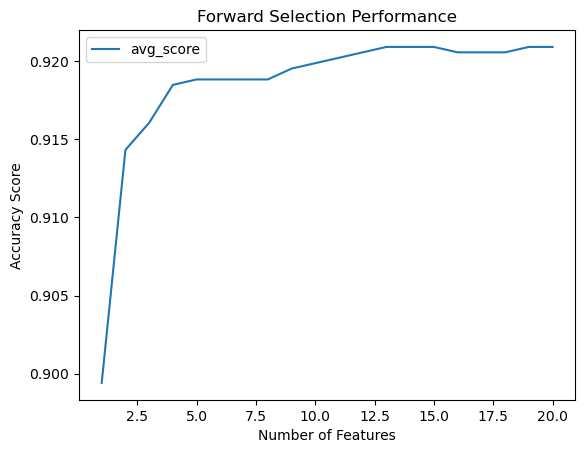

In [15]:
# printing the selected features from forward selection
print("Selected Features:", sfs.k_feature_names_)

scr = sfs.k_score_
print("Accuracy Score:", scr)

# plot the performance of the model with different feature subsets
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_df["avg_score"] = sfs_df["avg_score"].astype(float)
fig, ax = plt.subplots()
sfs_df.plot(kind="line", y="avg_score", ax=ax)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Accuracy Score")
ax.set_title("Forward Selection Performance")
plt.show()

### Backward Elimination

In [17]:
sfs = SFS(LogisticRegression(penalty='l1', C=1, solver='liblinear'), 
           k_features=20, 
           forward=False, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           n_jobs=-1,
           cv=3)

sfs.fit(X_train, y_train)

C:\Users\vyaas\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\vyaas\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:  1.3min finished

[2024-01-09 22:34:41] Features: 38/20 -- score: 0.9181408255289628[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:  1.2min finished

[2024-01-09 22:35:51] Features: 37/20 -- score: 0.9188345473465139[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:  1.0min finished

[2024-01-09 22:36:51] Features: 36/20 --

SequentialFeatureSelector(cv=3,
                          estimator=LogisticRegression(C=1, penalty='l1',
                                                       solver='liblinear'),
                          forward=False, k_features=(20, 20), n_jobs=-1,
                          scoring='accuracy', verbose=2)

Selected Features: ('x_1', 'x_113', 'x_124', 'x_127', 'x_18', 'x_2', 'x_27', 'x_28', 'x_33', 'x_42', 'x_44', 'x_45', 'x_52', 'x_59', 'x_67', 'x_7', 'x_71', 'x_78', 'x_8', 'x_83')
Accuracy Score: 0.9223031564342697


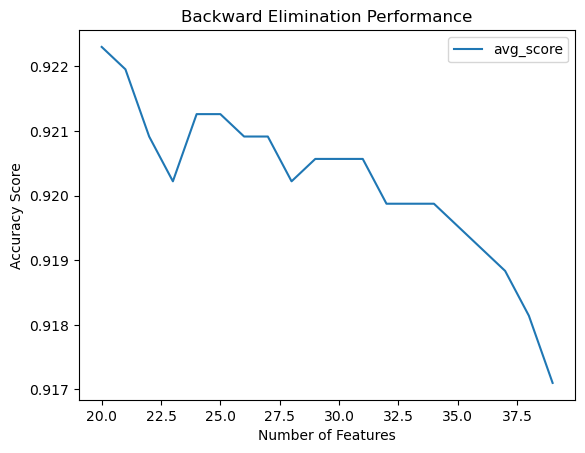

In [19]:
# printing the selected features from backward elimination
print("Selected Features:", sfs.k_feature_names_)

scr = sfs.k_score_
print("Accuracy Score:", scr)

# plot the performance of the model with different feature subsets
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_df["avg_score"] = sfs_df["avg_score"].astype(float)
fig, ax = plt.subplots()
sfs_df.plot(kind="line", y="avg_score", ax=ax)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Accuracy Score")
ax.set_title("Backward Elimination Performance")
plt.show()

### Recursive feature elimination with cross validation and random forest classification

In [22]:
rfecv = RFECV(estimator=RandomForestClassifier(), step=1, cv=5, scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 13
Best features : Index(['x_1', 'x_12', 'x_18', 'x_25', 'x_28', 'x_33', 'x_44', 'x_59', 'x_7',
       'x_70', 'x_77', 'x_8', 'x_83'],
      dtype='object')


In [23]:
X_train_rfecv = X_train[X_train.columns[rfecv.support_]]
X_test_rfecv = X_test[X_test.columns[rfecv.support_]]

model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [24]:
model.score(X_test, y_test)

0.9037216828478964

### Exhaustive Feature Selection

In [ ]:
efs = EFS(LogisticRegression(penalty='l1', solver='liblinear', C=1), min_features=20, max_features=20, scoring='accuracy', print_progress=True, cv=5, n_jobs=-1)
efs = efs.fit(X_train, y_train)

In [ ]:
print('Best accuracy score: %.2f' %efs.best_score_)
print('Best subset (indices):', efs.best_idx_)
print('Best subset (corresponding names):', efs.best_f eature_names_)

### Genetic Feature Selection

In [25]:
clf = LogisticRegression(penalty='l1', C=1, solver='liblinear')

evolved_estimator = GAFeatureSelectionCV(
    estimator=clf,
    cv=3,
    scoring="accuracy",
    population_size=15,
    generations=10,
    n_jobs=-1,
    verbose=True,
    keep_top_k=20,
    elitism=True,
)

evolved_estimator.fit(X_train, y_train)
features = evolved_estimator.support_

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	15    	0.907064	0.00804385 	0.920569   	0.896982   
1  	30    	0.913331	0.00458743 	0.920569   	0.902185   
2  	30    	0.912406	0.00687434 	0.920916   	0.899063   
3  	30    	0.915921	0.0020688  	0.920916   	0.911204   
4  	30    	0.916245	0.00500229 	0.921263   	0.901492   
5  	30    	0.912753	0.00752069 	0.921263   	0.897676   
6  	30    	0.920083	0.00236883 	0.921609   	0.913978   
7  	30    	0.920037	0.00236228 	0.921609   	0.913978   
8  	30    	0.91791 	0.00731941 	0.921609   	0.898717   
9  	30    	0.917216	0.00585317 	0.921609   	0.900451   
10 	30    	0.91828 	0.00543706 	0.921609   	0.89941    


C:\Users\vyaas\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [27]:
evolved_estimator.score(X_test, y_test)

C:\Users\vyaas\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but GAFeatureSelectionCV was fitted without feature names
  warnings.warn(


0.906957928802589

### XGBoost Test

In [28]:
# define a XG Boost Classifier model, for testing
model2 = xgb.XGBClassifier()
# fit the model on the whole dataset (37 features)
model2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [29]:
model2.score(X_test, y_test)

0.88915857605178

### Ensemble method

In [88]:
df.head

<bound method NDFrame.head of        x_1  x_109  x_113  x_12  x_124  x_127  x_144  x_16  x_18  x_2  ...  \
0     5099      1      5   156     35     -2      1    40   999    7  ...   
1     5191      0      1   164     16      1      5     4   999    5  ...   
2     5228      1      0   774     75      1      5    12   999    4  ...   
3     5228      1      1   747      4      1      5    69   999    3  ...   
4     5196      1      5    29     28      0      4    32   999    6  ...   
...    ...    ...    ...   ...    ...    ...    ...   ...   ...  ...  ...   
4114  5228      1      5   197     82      1      5     6   999    4  ...   
4115  5228      1      5   949     72      1      5     2   999    6  ...   
4116  5099      1      1   478     41     -2      1    25   999    1  ...   
4117  5228      1      0   554     36      1      5    68   999    0  ...   
4118  5196      1      0   143     26      0      4    21   999    1  ...   

      x_73  x_77  x_78  x_8  x_80  x_83  x_89

In [157]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif, RFE, VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector
from scipy.stats import zscore

# Standardize the features (optional but often recommended for logistic regression)
scaler = StandardScaler()

# List to store the top 20 features selected by each method
top_20_features_list = []

# List to store accuracies for each method
accuracies = []

df = X_train + X_test
# Method 1: Mutual Information
mi_selector = SelectKBest(mutual_info_classif, k=20)
X_train_mi = mi_selector.fit_transform(X_train, y_train)
X_test_mi = mi_selector.transform(X_test)
top_20_features_list.append(df.columns[mi_selector.get_support()])

# Calculate accuracy for Mutual Information
logreg_mi = LogisticRegression()
logreg_mi.fit(X_train_mi, y_train)
y_pred_mi = logreg_mi.predict(X_test_mi)
accuracy_mi = accuracy_score(y_test, y_pred_mi)
if accuracy_mi >= 0:
    accuracies.append(accuracy_mi)
else:
    accuracies.append(0)

# Method 2: ANOVA F-value
anova_selector = SelectKBest(f_classif, k=20)
X_train_anova = anova_selector.fit_transform(X_train, y_train)
X_test_anova = anova_selector.transform(X_test)
top_20_features_list.append(df.columns[anova_selector.get_support()])

# Calculate accuracy for ANOVA F-value
logreg_anova = LogisticRegression()
logreg_anova.fit(X_train_anova, y_train)
y_pred_anova = logreg_anova.predict(X_test_anova)
accuracy_anova = accuracy_score(y_test, y_pred_anova)
if accuracy_anova >= 0:
    accuracies.append(accuracy_anova)
else:
    accuracies.append(0)

# Method 3: Recursive Feature Elimination (RFE)
logreg_rfe = LogisticRegression()
rfe_selector = RFE(estimator=logreg_rfe, n_features_to_select=20)
X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
X_test_rfe = rfe_selector.transform(X_test)
top_20_features_list.append(df.columns[rfe_selector.support_])

# Calculate accuracy for Recursive Feature Elimination
logreg_rfe.fit(X_train_rfe, y_train)
y_pred_rfe = logreg_rfe.predict(X_test_rfe)
accuracy_rfe = accuracy_score(y_test, y_pred_rfe)
if accuracy_rfe >= 0:
    accuracies.append(accuracy_rfe)
else:
    accuracies.append(0)

# Method 5: SelectFromModel with L1 Regularization
logreg_l1 = LogisticRegression(penalty="l1", solver="liblinear", C=0.1)
selector_l1 = SelectFromModel(logreg_l1, max_features=20)
X_train_l1 = selector_l1.fit_transform(X_train, y_train)
X_test_l1 = selector_l1.transform(X_test)
top_20_features_list.append(df.columns[selector_l1.get_support()])

# Calculate accuracy for SelectFromModel with L1 Regularization
logreg_l1.fit(X_train_l1, y_train)
y_pred_l1 = logreg_l1.predict(X_test_l1)
accuracy_l1 = accuracy_score(y_test, y_pred_l1)
if accuracy_l1 >= 0:
    accuracies.append(accuracy_l1)
else:
    accuracies.append(0)

# Method 6: Tree-based Methods (RandomForestClassifier for feature importances)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
top_features_indices = np.argsort(rf_classifier.feature_importances_)[::-1][:20]
X_train_rf = X_train.iloc[:, top_features_indices]
X_test_rf = X_test.iloc[:, top_features_indices]
top_20_features_list.append(df.columns[top_features_indices])

# Calculate accuracy for Tree-based Methods
logreg_rf = LogisticRegression()
logreg_rf.fit(X_train_rf, y_train)
y_pred_rf = logreg_rf.predict(X_test_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
if accuracy_rf >= 0:
    accuracies.append(accuracy_rf)
else:
    accuracies.append(0)
print(accuracies)
# Remove methods with accuracy less than 91%
filtered_methods_indices = [i for i, acc in enumerate(accuracies) if acc > 0]
filtered_top_20_features = [top_20_features_list[i] for i in filtered_methods_indices]
filtered_accuracies = [accuracies[i] for i in filtered_methods_indices]
# Combine the scores from each method with weights based on accuracies
weights = np.array(filtered_accuracies) / sum(filtered_accuracies)
print(weights.shape)
ensemble_scores = np.average([mi_selector.scores_, anova_selector.scores_, rfe_selector.ranking_,
                              selector_l1.estimator_.coef_.flatten(),
                              rf_classifier.feature_importances_], axis=0, weights=weights)

# Select the top 20 features based on ensemble scores
top_20_indices_ensemble = np.argsort(ensemble_scores)[::-1][:20]
X_train_ensemble = X_train.iloc[:, top_20_indices_ensemble]
X_test_ensemble = X_test.iloc[:, top_20_indices_ensemble]
filtered_top_20_features.append(df.columns[top_20_indices_ensemble])

# Apply z-score after feature selection
X_train_scaled = scaler.fit_transform(X_train_ensemble)
X_test_scaled = scaler.transform(X_test_ensemble)

# Print columns selected by the weighted ensemble
print("\nColumns selected by Weighted Ensemble:")
selected_columns_ensemble = df.columns[top_20_indices_ensemble]
print(selected_columns_ensemble)

# Train logistic regression with top 20 features selected by weighted ensemble
logreg_weighted_ensemble = LogisticRegression(penalty='l1',C=1,solver='liblinear')
logreg_weighted_ensemble.fit(X_train_scaled, y_train)
y_pred_weighted_ensemble = logreg_weighted_ensemble.predict(X_test_scaled)
accuracy_weighted_ensemble = accuracy_score(y_test, y_pred_weighted_ensemble)
print("Accuracy with Weighted Ensemble:", accuracy_weighted_ensemble)

[0.9077669902912622, 0.9061488673139159, 0.9045307443365695, 0.9061488673139159, 0.9029126213592233]
(5,)

Columns selected by Weighted Ensemble:
Index(['x_1', 'x_18', 'x_80', 'x_127', 'x_57', 'x_45', 'x_99', 'x_73', 'x_38',
       'x_28', 'x_77', 'x_113', 'x_89', 'x_44', 'x_124', 'x_27', 'x_7',
       'x_109', 'x_91', 'x_16'],
      dtype='object')
Accuracy with Weighted Ensemble: 0.9045307443365695


## **Results and Conclusion**

### **Optimal features selected**

**'x_1', 'x_18', 'x_80', 'x_127', 'x_57', 'x_45', 'x_99', 'x_73', 'x_38',
       'x_28', 'x_77', 'x_113', 'x_89', 'x_44', 'x_124', 'x_27', 'x_7',
       'x_109', 'x_91', 'x_16'**